## Exercício 5 - Item b: Equação de Poisson 1D

Vamos resolver a equação de Poisson no domínio unidimensional:

$$
\frac{\partial^2 u}{\partial x^2} = -\pi^2 \sin(\pi x), \quad x \in [-1, 1]
$$

Com as condições de contorno do tipo Dirichlet:

$$
u(-1) = 0 \\
u(1) = 0
$$

A **solução analítica** é:

$$
u(x) = \sin(\pi x)
$$

A implementação será feita com a biblioteca **DeepXDE**.


In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Definição da equação de Poisson 1D
def pde(x, u):
    du_xx = dde.grad.hessian(u, x)
    return du_xx + dde.backend.sin(np.pi * x) * (np.pi ** 2)


In [3]:
# Condições de contorno u(-1) = 0 e u(1) = 0
geom = dde.geometry.Interval(-1, 1)
bc_left = dde.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geom, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 1))


In [4]:
def sol_analitica(x):
    return np.sin(np.pi * x)


In [5]:
# Dados do problema
data = dde.data.PDE(
    geom, pde, [bc_left, bc_right],
    num_domain=200, num_boundary=20,
    solution=sol_analitica,
    num_test=1000
)

# Arquitetura da rede
net = dde.maps.FNN([1] + [30] * 3 + [1], "tanh", "Glorot uniform")

# Modelo
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)


Compiling model...
'compile' took 4.439669 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.51e+01, 5.26e-02, 5.26e-02]    [4.96e+01, 5.26e-02, 5.26e-02]    []  
1000      [8.18e-04, 9.57e-07, 1.37e-06]    [6.58e-04, 9.57e-07, 1.37e-06]    []  
2000      [2.60e-04, 6.97e-08, 7.43e-08]    [2.35e-04, 6.97e-08, 7.43e-08]    []  
3000      [1.55e-04, 2.52e-07, 2.06e-08]    [1.48e-04, 2.52e-07, 2.06e-08]    []  
4000      [1.77e-04, 4.14e-06, 7.82e-06]    [1.89e-04, 4.14e-06, 7.82e-06]    []  
5000      [5.20e-05, 9.94e-09, 3.17e-09]    [5.01e-05, 9.94e-09, 3.17e-09]    []  

Best model at step 5000:
  train loss: 5.20e-05
  test loss: 5.01e-05
  test metric: []

'train' took 15.402864 s



In [6]:
model.compile("L-BFGS")
model.train()


Compiling model...
'compile' took 0.000228 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [5.20e-05, 9.94e-09, 3.17e-09]    [5.01e-05, 9.94e-09, 3.17e-09]    []  
5169      [2.00e-06, 3.51e-13, 9.23e-12]    [2.05e-06, 3.51e-13, 9.63e-12]    []  

Best model at step 5169:
  train loss: 2.00e-06
  test loss: 2.05e-06
  test metric: []

'train' took 0.770966 s



(<deepxde.model.LossHistory at 0x14c2d5bb950>,
 <deepxde.model.TrainState at 0x14c451e1670>)

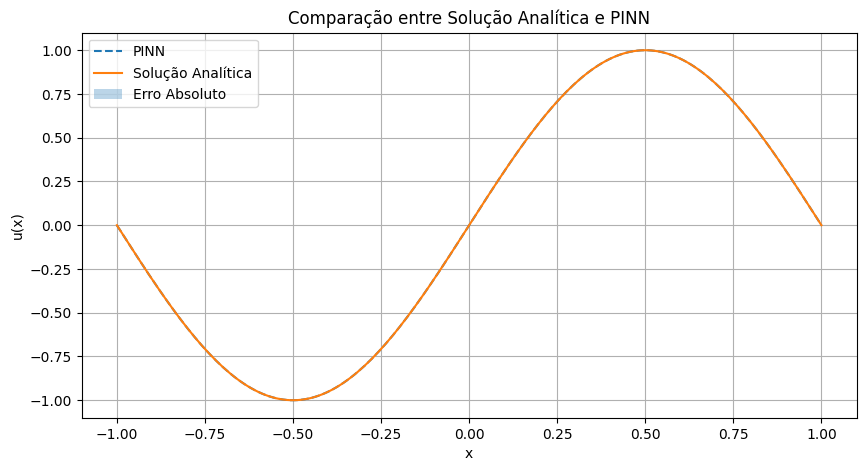

Erro absoluto médio: 8.148830694109405e-06


In [7]:
# Geração de pontos para teste
X = np.linspace(-1, 1, 200).reshape(-1, 1)
u_pred = model.predict(X)
u_true = sol_analitica(X)

# Erro absoluto
erro = np.abs(u_pred - u_true)

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(X, u_pred, label="PINN", linestyle='--')
plt.plot(X, u_true, label="Solução Analítica", linestyle='-')
plt.fill_between(X.flatten(), erro.flatten(), alpha=0.3, label="Erro Absoluto")
plt.title("Comparação entre Solução Analítica e PINN")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.savefig('../imagens/poisson_1d_comparacao.png', dpi=300)
plt.show()
# Erro absoluto médio
print("Erro absoluto médio:", np.mean(erro))
